```
This notebook runs small ensembles in the Oslo fjord where we perturb a
single parameter for each ensemble to look at the resulting variance 
and how it affects a drift trajectory.

Copyright (C) 2023 SINTEF Digital

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [2]:
import sys
gpuocean_path = [p[:-4] for p in sys.path if (p.endswith("gpuocean/src") or p.endswith("gpuocean\\src"))][0]
import git
repo = git.Repo(gpuocean_path)
print("GPUOcean code from:", repo.head.object.hexsha, "on branch", repo.active_branch.name)

GPUOcean code from: ca2502127969ef8eb828499ac582af6fc10a2747 on branch reduced_gravity


In [3]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime, copy
from IPython.display import display
import xarray as xr


#For plotting
import matplotlib
from matplotlib import pyplot as plt

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

In [4]:
from gpuocean.utils import IPythonMagic, Common, NetCDFInitialization, WindStress, OceanographicUtilities

from gpuocean.SWEsimulators import CDKLM16
import animation_utils

from gpuocean.utils import Observation
from gpuocean.drifters import GPUDrifterCollection
from gpuocean.dataassimilation import DataAssimilationUtils as dautils

In [5]:
%cuda_context_handler gpu_ctx

### Read input file and typical parameters

In [6]:
source_url = "/sintef/data/OsloFjord/test_polstere_1h_0007.nc"
nc = Dataset(source_url)
ds = xr.open_dataset(source_url)

# Grid and discretization
dimY, dimX = ds.h.data.shape
x0, x1, y0, y1 = 5, dimX-5, 175, dimY-5
t_start = 5*24
t_stop =  5*24 + 6
T = (t_stop-t_start)*3600  #Input
timestep_indices = [list(np.arange(t_start, t_stop+1))]


### Generating wind

In [7]:
from gpuocean.utils import WindStress

def generate_wind_field(wind_angle_deg, t_start_index, T):
    """Generating WindStress object with spatially constant, hourly varying wind 
    according to the standard shape in Oslofjord (see Oslofjord-ArtificialParameters.ipynb)
    
    wind_angle_deg - angle of wind field towards north in degree!
    t_start_index  - index for the time when generated wind field is supposed to start
    T              - time span for which the wind field is generated 
    """

    wind_angle = np.deg2rad(wind_angle_deg)

    # Reference wind speed for 0 - 24h 
    wind_u_ref = np.zeros(24)
    wind_u_ref[:10] = -0.5*(np.sin(2*np.pi*(np.arange(0,10)-2.5)/10)+1)
    wind_u_ref[10:] = 5*(np.sin(2*np.pi*(np.arange(10,24)+0.5)/14)+1)

    # Wind fields for 0 - 24h
    wind_u = list(np.cos(wind_angle)*wind_u_ref[:,np.newaxis][:,np.newaxis].astype(np.float32))
    wind_v = list(np.sin(wind_angle)*wind_u_ref[:,np.newaxis][:,np.newaxis].astype(np.float32))

    # Shifting that reference hours align with t_0
    shift = datetime.datetime.utcfromtimestamp(nc["ocean_time"][t_start_index]).hour
    for shift_hour in range(shift):
        wind_u.append(wind_u.pop(0))
        wind_v.append(wind_v.pop(0))

    # Cut relevant time span
    wind_u = wind_u[0:int(T/3600+1)]
    wind_v = wind_v[0:int(T/3600 +1)]

    # Construct time array in simulator time (starting with 0)
    ts = np.arange(T+1, step=3600)

    # Init WindStress object
    wind = WindStress.WindStress(t=ts, wind_u=wind_v, wind_v=wind_u)
    wind.compute_wind_stress_from_wind()

    return wind 

# Reference values

In [8]:
ref_wind_direction = 45.0
ref_wind = generate_wind_field(ref_wind_direction, t_start, T)
print(ref_wind.wind_u)
print(ref_wind.wind_v)
ref_wind_stress_factor = 0.3
ref_windage = 0.01

[array([[2.7488036]], dtype=float32), array([[4.322264]], dtype=float32), array([[5.739903]], dtype=float32), array([[6.72094]], dtype=float32), array([[7.071068]], dtype=float32), array([[6.72094]], dtype=float32), array([[5.739903]], dtype=float32)]
[array([[2.7488036]], dtype=float32), array([[4.322264]], dtype=float32), array([[5.739903]], dtype=float32), array([[6.72094]], dtype=float32), array([[7.071068]], dtype=float32), array([[6.72094]], dtype=float32), array([[5.739903]], dtype=float32)]


In [9]:
# Baroclinic initial conditions
ref_barotropic_data_args, ref_baroclinic_data_args = NetCDFInitialization.getCombinedInitialConditions(source_url, x0, x1, y0, y1, 1024.0, timestep_indices=timestep_indices, norkyst_data=False, land_value=0.0, download_data=False)
ref_sim = CDKLM16.CDKLM16(gpu_ctx, **NetCDFInitialization.removeMetadata(ref_baroclinic_data_args),  dt=0.0)
barotropic_ref_sim = CDKLM16.CDKLM16(gpu_ctx, **NetCDFInitialization.removeMetadata(ref_barotropic_data_args), dt=0.0)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


# Perturbation values

In [ ]:
# Mixed layer depth (MLD) 
# Can be explored coupled or decoupled with the reduced gravity constant
mld_dens_samples = np.arange(1022, 1024.6, 0.5)
mld_samples_data_args = [None]*len(mld_dens_samples)
recompute_mld_data_args = False
if recompute_mld_data_args or mld_samples_data_args[0] is None:
    for i in range(len(mld_dens_samples)):
        _, mld_samples_data_args[i] = NetCDFInitialization.getCombinedInitialConditions(source_url, x0, x1, y0, y1, 
                                                                                        mld_dens_samples[i], timestep_indices=timestep_indices, norkyst_data=False, land_value=0.0, download_data=False)
        print(mld_samples_data_args[i]["g"])
print(mld_dens_samples)

#barotropic_data_args1, baroclinic_data_args1 = NetCDFInitialization.getCombinedInitialConditions(source_url, x0, x1, y0, y1, 1024.1, timestep_indices=timestep_indices, norkyst_data=False, land_value=0.0, download_data=False)

In [ ]:
# Gravity
g_samples = [None]*len(mld_dens_samples)
for i in range(len(mld_dens_samples)):
    g_samples[i] = mld_samples_data_args[i]["g"]

g_extra_samples = np.arange(0.01, 0.11, 0.01)
print(ref_baroclinic_data_args["g"])


In [10]:
# Wind
wind_directions = np.arange(0, 95, 5)
wind_direction_samples = [None]*len(wind_directions)

for i in range(len(wind_directions)):
    wind_direction_samples[i] = generate_wind_field(wind_directions[i], t_start, T)

wind_stress_samples = np.arange(0.0, 0.5, 0.05)
windage_samples = np.arange(0.0, 0.0525, 0.0025)

print(len(wind_direction_samples), len(wind_stress_samples), len(windage_samples))

19 10 21


In [11]:
# Friction
print("Reference friction coefficients for baroclinic and barotropic:", ref_baroclinic_data_args["r"], ref_barotropic_data_args["r"])
friction_samples = np.arange(0, 0.0055, 0.0005)
len(friction_samples)

Reference friction coefficients for baroclinic and barotropic: 0.003 0.003


11

### Looking at some of the sample distributions

Exception caught: Resetting to CUDA context gpu_ctx
Traceback (most recent call last):
  File "/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3552, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_2161968/3351427437.py", line 3, in <module>
    im = axs[0].imshow(mld_samples_data_args[0]["eta0"], vmin=0, vmax=15, cmap="coolwarm")
NameError: name 'mld_samples_data_args' is not defined


NameError: name 'mld_samples_data_args' is not defined

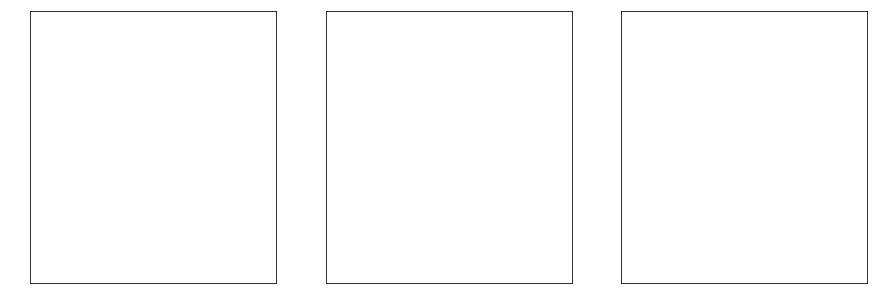

In [15]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

im = axs[0].imshow(mld_samples_data_args[0]["eta0"], vmin=0, vmax=15, cmap="coolwarm")
axs[0].set_title("args1")
plt.colorbar(im, ax=axs[0], shrink=0.5)

axs[0].axvline(x=120, c="black")

num_mld_samples = len(mld_samples_data_args)
im = axs[1].imshow(mld_samples_data_args[num_mld_samples-1]["eta0"], vmin=0, vmax=15, cmap="coolwarm")
axs[1].set_title("args")
plt.colorbar(im, ax=axs[1], shrink=0.5)

im = axs[2].imshow(mld_samples_data_args[0]["eta0"]-mld_samples_data_args[num_mld_samples-1]["eta0"], vmin=-5, vmax=5, cmap="coolwarm")
axs[2].set_title("args low - args high")
plt.colorbar(im, ax=axs[2], shrink=0.5)

In [16]:
plt.figure()
for i in range(len(mld_samples_data_args)):
    plt.plot(mld_samples_data_args[i]["eta0"][:, 120])

plt.figure()
for i in range(len(mld_samples_data_args)):
    plt.plot(mld_samples_data_args[i]["hu0"][:, 120])

plt.figure()
for i in range(len(mld_samples_data_args)):
    plt.plot(mld_samples_data_args[i]["hv0"][:, 120])



Exception caught: Resetting to CUDA context gpu_ctx
Traceback (most recent call last):
  File "/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3552, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_2161968/645680293.py", line 2, in <module>
    for i in range(len(mld_samples_data_args)):
NameError: name 'mld_samples_data_args' is not defined


NameError: name 'mld_samples_data_args' is not defined

<Figure size 432x288 with 0 Axes>

# Utility functions to run ensembles and plot variance and trajectories 

In [120]:
def run_sample(data_args_in, g=None, wind=None, wind_stress_factor=None, windage=0.0, friction=None, end_time=T, pert_init_drifter=False):
    data_args = copy.deepcopy(data_args_in)
    if g is not None:
        data_args["g"] = g
    if wind is not None:
        data_args["wind"] = wind
    if wind_stress_factor is not None:
        data_args["wind_stress_factor"] = wind_stress_factor
    if friction is not None:
        data_args["r"] = friction
    
    # Create sim
    sim = CDKLM16.CDKLM16(gpu_ctx, **NetCDFInitialization.removeMetadata(data_args),  dt=0.0)

    # Make observation object to log drift trajectory
    observation_type = dautils.ObservationType.UnderlyingFlow 
    observation_args = {'observation_type': observation_type,
                    'nx': sim.nx, 'ny': sim.ny,
                    'domain_size_x': sim.nx*sim.dx,
                    'domain_size_y': sim.ny*sim.dy,
                    'land_mask': sim.getLandMask()
                    }
    trajectories = Observation.Observation(**observation_args)

    # Create and initialize drifter objects
    #initx = [ 6000]
    #inity = [12000]
    initx = [ 6000, 8000, 5000,  12000, 15000, 4000]
    inity = [12000, 3000, 7500, 22000, 16000, 15000]
    num_drifters = len(initx)

    if pert_init_drifter:
        initx += np.random.normal(scale=100, size=num_drifters)
        inity += np.random.normal(scale=100, size=num_drifters)

    drifters = GPUDrifterCollection.GPUDrifterCollection(gpu_ctx, num_drifters,
                                                        boundaryConditions = sim.boundary_conditions,
                                                        domain_size_x = trajectories.domain_size_x,
                                                        domain_size_y = trajectories.domain_size_y,
                                                        gpu_stream = sim.gpu_stream,
                                                        wind=data_args["wind"],
                                                        wind_drift_factor = windage
                                                        )

    drifter_pos_init = np.array([initx, inity]).T
    drifters.setDrifterPositions(drifter_pos_init)

    # Attach drifters and log init position
    sim.attachDrifters(drifters)
    trajectories.add_observation_from_sim(sim)

    # Simulation loop, logging drifter positions every 2 min
    drifter_log_dt = 2*60
    t = 0
    while t < end_time:
        dt = min(drifter_log_dt, end_time - t)
        sim.step(dt)
        t = t + dt
        trajectories.add_observation_from_sim(sim)

    # return final ocean state and trajectory
    eta, hu, hv = sim.download()
    return {"eta": eta, "hu": hu, "hv": hv, "trajectories": trajectories}


In [18]:

def _get_statistics(results, ref_sim):
    N = len(results)
    etas = np.zeros((N, results[0]["eta"].shape[0], results[0]["eta"].shape[1]))
    hus  = np.zeros((N, results[0]["hu"].shape[0],  results[0]["hu"].shape[1]))
    hvs  = np.zeros((N, results[0]["hv"].shape[0],  results[0]["hv"].shape[1]))
    for i in range(N):
        etas[i,:,:] = results[i]["eta"]
        hus[i,:,:] = results[i]["hu"]
        hvs[i,:,:] = results[i]["hv"]

    _, Hm = ref_sim.downloadBathymetry()


    v = np.sqrt((hus/(etas + Hm))**2 + (hvs/(etas + Hm))**2)

    mean_eta = np.ma.MaskedArray(np.mean(etas, axis=0), mask=results[0]["eta"].mask)
    mean_v   = np.ma.MaskedArray(np.mean(v,    axis=0), mask=results[0]["eta"].mask)
    var_eta  = np.ma.MaskedArray(np.var(etas,  axis=0), mask=results[0]["eta"].mask)
    var_v    = np.ma.MaskedArray(np.var(v,     axis=0), mask=results[0]["eta"].mask)


    return mean_eta, mean_v, var_eta, var_v


def _plot_field(results, field, ref_sim, T, title, plot_trajectories=True, 
                cmap=plt.cm.Reds, vmin=0.0, vmax=0.5, filename=None):
    
    with plt.rc_context({'lines.color':'black', 
                        'text.color':'black', 
                        'axes.labelcolor':'black', 
                        'xtick.color':'black',
                        'ytick.color':'black'}):
        fig, ax = plt.subplots(1,1, figsize=(7,7))
        ax.tick_params(axis='both', which='major', labelsize=15)

        domain_extent = [0, ref_sim.nx*ref_sim.dx/1000, 0, ref_sim.ny*ref_sim.dy/1000]

        cmap_cp = copy.copy(cmap)
        cmap_cp.set_bad("grey", alpha = 1.0)

        im = ax.imshow(field, interpolation="none", origin='lower', 
                       cmap=cmap_cp, 
                       vmin=vmin, vmax=vmax, 
                       extent=domain_extent)
        if plot_trajectories:
            num_drifters = results[0]["trajectories"].get_num_drifters()
            for d in range(num_drifters):
                for i in range(len(results)):
                    drifter_path = results[i]["trajectories"].get_drifter_path(d, 0, T, in_km = True)[0]
                    start_pos = drifter_path[0,:]
                    circ_start = matplotlib.patches.Circle((start_pos[0], start_pos[1]), 
                                                                    0.01, color = 'blue',
                                                                    fill=True, zorder=10)
                    ax.add_patch(circ_start)

                    ax.plot(drifter_path[:,0], drifter_path[:,1], color="cornflowerblue", ls="-", zorder=5)
                    end_pos = drifter_path[-1,:]
                    ax.plot(end_pos[0], end_pos[1], 'x', color='darkblue', zorder=11)
    
        cb = plt.colorbar(im, ax=ax) #, shrink=0.8)
        cb.ax.tick_params(labelsize=15)

        plt.title(title+"\n", fontsize=16)
        plt.tight_layout()

        if filename is not None:
            folder = "sensitivity_figs"
            os.makedirs(folder, exist_ok=True)
            plt.savefig(os.path.join(folder, filename+".pdf"))


def plot_drifters_and_variance(results, ref_sim, T, suptitle, filename=None, vmax=None):
    # results are list with dicts [{eta, hu, hv, trajectories}]

    mean_eta, mean_vel, var_eta, var_vel = _get_statistics(results, ref_sim)

    if vmax is None:
        vmax = max(var_vel.max()/4, 1e-6)

    _plot_field(results, var_vel, ref_sim, T, suptitle, vmin=0, vmax=vmax, filename=filename)
    #_plot_field(results, var_eta, ref_sim, T, "MLD variance", vmin=0, vmax=4)
    
    print("Maximum velocity: ", mean_vel.max(), var_vel.max())

#plot_drifters_and_variance(mld_dens_results, ref_sim, T, "Perturbing MLD init")

# Plot initial positions of the drifters with annotations

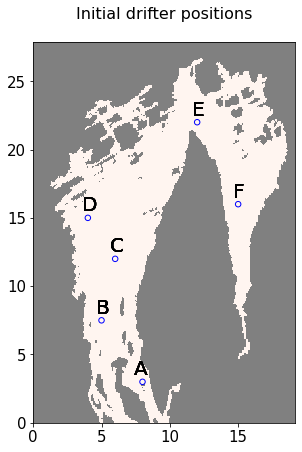

In [19]:
initx = [ 6000, 8000, 5000,  12000, 15000, 4000]
inity = [12000, 3000, 7500, 22000, 16000, 15000]

with plt.rc_context({'lines.color':'black', 
                    'text.color':'black', 
                    'axes.labelcolor':'black', 
                    'xtick.color':'black',
                    'ytick.color':'black'}):
    fig, ax = plt.subplots(1,1, figsize=(7,7))
    ax.tick_params(axis='both', which='major', labelsize=15)

    domain_extent = [0, ref_sim.nx*ref_sim.dx/1000, 0, ref_sim.ny*ref_sim.dy/1000]

    cmap_cp = copy.copy(plt.cm.Reds)
    cmap_cp.set_bad("grey", alpha = 1.0)
    background_field = np.zeros_like(ref_baroclinic_data_args["eta0"])

    im = ax.imshow(background_field, interpolation="none", origin='lower', 
                cmap=cmap_cp, 
                extent=domain_extent)

    for d in range(len(initx)):
        circ_start = matplotlib.patches.Circle((initx[d]/1000, inity[d]/1000), 
                                                0.2, color = 'blue',
                                                fill=False, zorder=10)
        ax.add_patch(circ_start)

        # plt.annotate("hei",(initx[0]-1, inity[0]+1))
        annotation_fontsize = 20
        ax.annotate("C",[initx[0]/1000-0.4, inity[0]/1000+0.5], fontsize=annotation_fontsize )
        ax.annotate("A",[initx[1]/1000-0.6, inity[1]/1000+0.5], fontsize=annotation_fontsize )
        ax.annotate("B",[initx[2]/1000-0.4, inity[2]/1000+0.5], fontsize=annotation_fontsize )
        ax.annotate("E",[initx[3]/1000-0.4, inity[3]/1000+0.5], fontsize=annotation_fontsize )
        ax.annotate("F",[initx[4]/1000-0.4, inity[4]/1000+0.5], fontsize=annotation_fontsize )
        ax.annotate("D",[initx[5]/1000-0.4, inity[5]/1000+0.5], fontsize=annotation_fontsize )


    plt.title("Initial drifter positions\n", fontsize=16)
    #plt.tight_layout()

    if True:
        folder = "sensitivity_figs"
        os.makedirs(folder, exist_ok=True)
        plt.savefig(os.path.join(folder, "initial_drifter_positions.pdf"))

# Run experiments and plot results

Baroclinic reference

In [20]:
ref_baroclinic_result = [run_sample(ref_baroclinic_data_args)]

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


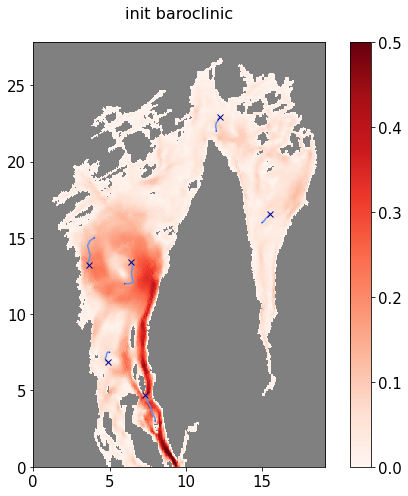

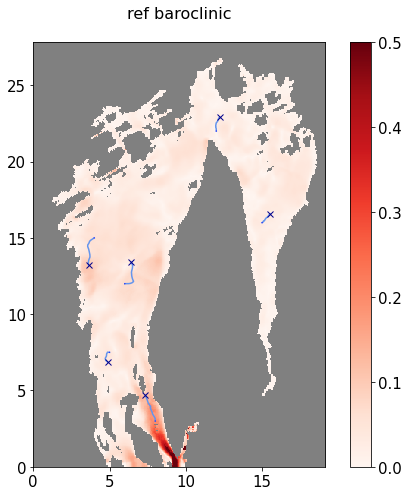

In [21]:
initV = np.ma.sqrt((ref_baroclinic_data_args["hu0"]/ref_baroclinic_data_args["eta0"])**2 + (ref_baroclinic_data_args["hv0"]/ref_baroclinic_data_args["eta0"])**2)
refV = np.ma.sqrt((ref_baroclinic_result[0]["hu"]/ref_baroclinic_data_args["eta0"])**2 + (ref_baroclinic_result[0]["hv"]/ref_baroclinic_data_args["eta0"])**2)
_plot_field(ref_baroclinic_result, initV, ref_sim, T, "init baroclinic", plot_trajectories=True)
_plot_field(ref_baroclinic_result, refV, ref_sim, T, "ref baroclinic", plot_trajectories=True)

Barotropic reference

In [44]:
ref_barotropic_result = [run_sample(ref_barotropic_data_args)]

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


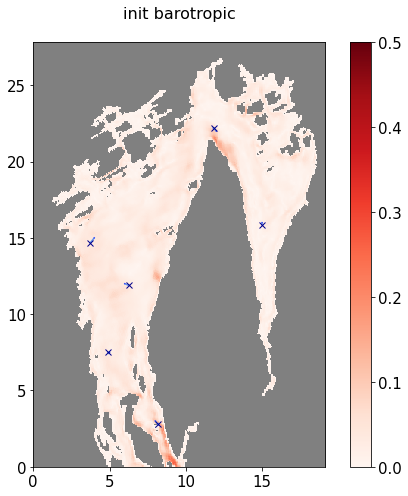

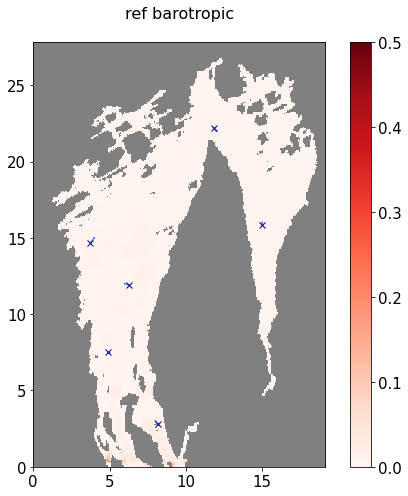

In [48]:
initV = np.ma.sqrt((ref_barotropic_data_args["hu0"]/Dataset(source_url)["h"][y0:y1, x0:x1])**2 + (ref_barotropic_data_args["hv0"]/Dataset(source_url)["h"][y0:y1, x0:x1])**2)
refV = np.ma.sqrt((ref_barotropic_result[0]["hu"]/Dataset(source_url)["h"][y0:y1, x0:x1])**2 + (ref_barotropic_result[0]["hv"]/Dataset(source_url)["h"][y0:y1, x0:x1])**2)
_plot_field(ref_barotropic_result, initV, ref_sim, T, "init barotropic", plot_trajectories=True)
_plot_field(ref_barotropic_result, refV, ref_sim, T, "ref barotropic", plot_trajectories=True)

Barotropic wind direction

In [ ]:
# barotropic_wind_direction_results = [None]*len(wind_direction_samples)
# barotropic_wind_direction_results_no_windage = [None]*len(wind_direction_samples)
# for i in range(len(wind_direction_samples)):
#     barotropic_wind_direction_results[i] = run_sample(ref_barotropic_data_args, wind=wind_direction_samples[i], wind_stress_factor=ref_wind_stress_factor, windage=ref_windage)
#     barotropic_wind_direction_results_no_windage[i] = run_sample(ref_barotropic_data_args, wind=wind_direction_samples[i], wind_stress_factor=ref_wind_stress_factor, windage=0)

# plot_drifters_and_variance(barotropic_wind_direction_results, barotropic_ref_sim, T, "Barotropic wind direction", filename="barotropic_wind_dir")
# plot_drifters_and_variance(barotropic_wind_direction_results_no_windage, barotropic_ref_sim, T, "Barotropic wind direction (no windage)", filename="barotropic_wind_dir_nowindage")

### MLD coupled with gravity

In [ ]:
mld_dens_results = [None]*len(mld_dens_samples)
mld_dens_results_no_wind = [None]*len(mld_dens_samples)
for i in range(len(mld_dens_samples)):
    mld_dens_results[i] = run_sample(mld_samples_data_args[i], wind=ref_wind, wind_stress_factor=ref_wind_stress_factor, windage=ref_windage)
    mld_dens_results_no_wind[i] = run_sample(mld_samples_data_args[i])


In [ ]:
plot_drifters_and_variance(mld_dens_results, ref_sim, T, "MLD coupled with g'", filename="mld_coupled_g")
plot_drifters_and_variance(mld_dens_results_no_wind, ref_sim, T, "MLD coupled with g' (excl wind)", filename="mld_coupled_g_nowind")

### MLD decoupled from gravity

In [ ]:
mld_init_same_g_results = [None]*len(mld_dens_samples)
mld_init_same_g_results_no_wind = [None]*len(mld_dens_samples)
for i in range(len(mld_dens_samples)):
    mld_init_same_g_results[i] = run_sample(mld_samples_data_args[i], ref_baroclinic_data_args["g"], wind=ref_wind, wind_stress_factor=ref_wind_stress_factor, windage=ref_windage)
    mld_init_same_g_results_no_wind[i] = run_sample(mld_samples_data_args[i], ref_baroclinic_data_args["g"])

In [ ]:
plot_drifters_and_variance(mld_init_same_g_results, ref_sim, T, "MLD, same g'", filename="mld_decoupled_g")
plot_drifters_and_variance(mld_init_same_g_results_no_wind, ref_sim, T, "MLD, same g' (excl wind)", filename="mld_decoupled_g_nowind")

### Reduced gravity constant, with g computed from different potential densities

In [ ]:
g_results = [None]*len(mld_dens_samples)
g_results_no_wind = [None]*len(mld_dens_samples)
for i in range(len(mld_dens_samples)):
    g_results[i] = run_sample(ref_baroclinic_data_args, mld_samples_data_args[i]["g"], wind=ref_wind, wind_stress_factor=ref_wind_stress_factor, windage=ref_windage)
    g_results_no_wind[i] = run_sample(ref_baroclinic_data_args, mld_samples_data_args[i]["g"])


In [ ]:
plot_drifters_and_variance(g_results, ref_sim, T, "Perturbing g'", filename="g_decoupled_mdl")
plot_drifters_and_variance(g_results_no_wind, ref_sim, T, "Perturbing g' (excl wind)", filename="g_decoupled_mdl_nowind")

### Reduced gravities, with g' sampled directly

In [ ]:
g_results2 = [None]*len(g_extra_samples)
g_results2_no_wind = [None]*len(g_extra_samples)
for i in range(len(g_extra_samples)):
    g_results2[i] = run_sample(ref_baroclinic_data_args, g_extra_samples[i], wind=ref_wind, wind_stress_factor=ref_wind_stress_factor, windage=ref_windage)
    g_results2_no_wind[i] = run_sample(ref_baroclinic_data_args, g_extra_samples[i])


In [ ]:
plot_drifters_and_variance(g_results2, ref_sim, T, "g' [0.01, 0.1]", filename="g")
plot_drifters_and_variance(g_results2_no_wind, ref_sim, T, "g' [0.01, 0.1] (excl wind)", filename="g_nowind")

### Wind direction

In [ ]:
wind_direction_results = [None]*len(wind_direction_samples)
wind_direction_results_no_windage = [None]*len(wind_direction_samples)
for i in range(len(wind_direction_samples)):
    wind_direction_results[i] = run_sample(ref_baroclinic_data_args, wind=wind_direction_samples[i], wind_stress_factor=ref_wind_stress_factor, windage=ref_windage)
    wind_direction_results_no_windage[i] = run_sample(ref_baroclinic_data_args, wind=wind_direction_samples[i], wind_stress_factor=ref_wind_stress_factor, windage=0)


In [ ]:
plot_drifters_and_variance(wind_direction_results, ref_sim, T, "Wind direction", filename="wind_direction")
plot_drifters_and_variance(wind_direction_results_no_windage, ref_sim, T, "Wind direction (no windage)", filename="wind_direction_nowindage")


### Wind stress factor

In [ ]:
wind_stress_results = [None]*len(wind_stress_samples)
wind_stress_results_no_windage = [None]*len(wind_stress_samples)
for i in range(len(wind_stress_samples)):
    wind_stress_results[i] = run_sample(ref_baroclinic_data_args, wind=ref_wind, wind_stress_factor=wind_stress_samples[i], windage=ref_windage)
    wind_stress_results_no_windage[i] = run_sample(ref_baroclinic_data_args, wind=ref_wind, wind_stress_factor=wind_stress_samples[i], windage=0)


In [ ]:
plot_drifters_and_variance(wind_stress_results, ref_sim, T, "Wind stress", filename="wind_stress")
plot_drifters_and_variance(wind_stress_results_no_windage, ref_sim, T, "Wind stress (no windage)", filename="wind_stress_nowindage")

### Windage - wind contribution on advection

In [ ]:
windage_results = [None]*len(windage_samples)
for i in range(len(windage_samples)):
    windage_results[i] = run_sample(ref_baroclinic_data_args, wind=ref_wind, wind_stress_factor=ref_wind_stress_factor, windage=windage_samples[i])


In [ ]:
plot_drifters_and_variance(windage_results, ref_sim, T, "Windage", filename="windage")

In [ ]:
len(windage_results)

### Interface friction

In [ ]:
friction_results = [None]*len(friction_samples)
friction_results_no_windage = [None]*len(friction_samples)
for i in range(len(friction_samples)):
    friction_results[i] = run_sample(ref_baroclinic_data_args, wind=ref_wind, wind_stress_factor=ref_wind_stress_factor, windage=ref_windage, friction=friction_samples[i])
    friction_results_no_windage[i] = run_sample(ref_baroclinic_data_args, wind=ref_wind, wind_stress_factor=ref_wind_stress_factor, windage=0, friction=friction_samples[i])



In [ ]:
plot_drifters_and_variance(friction_results, ref_sim, T, "Inter-layer friction", filename="interface_friction")
plot_drifters_and_variance(friction_results_no_windage, ref_sim, T, "Inter-layer friction (no windage)", filename="interface_friction_nowindage")

### Barotropic windage

# Look at reference file
 

In [ ]:
ds

In [ ]:
ds.ubar

In [ ]:
ds.ubar.isel(ocean_time=120).plot()

plt.figure()
ds.h.isel().plot()

plt.figure()
ds.h.isel(xi_rho=120 + x0, eta_rho=slice(y0, y1)).plot()
plt.plot(barH[:, 120])

plt.figure()
ds.h.isel(xi_rho=slice(x0, x1), eta_rho=y0+250).plot()
plt.plot(barH[250, :])


plt.figure()
ds.ubar.isel(ocean_time=120, xi_u=slice(x0, x1), eta_rho=y0+250).plot()
plt.plot(ref_barotropic_data_args["hu0"][250, :]/(ref_barotropic_data_args["eta0"][250,:] +barH[250,:]))
plt.title("ubar cross section")

plt.figure()
ds.vbar.isel(ocean_time=120, xi_rho=slice(x0, x1), eta_v=y0+250).plot()
plt.plot(ref_barotropic_data_args["hv0"][250, :]/(ref_barotropic_data_args["eta0"][250,:] +barH[250,:]))
plt.title("vbar cross section")

plt.figure()
plt.imshow(barH, interpolation="none", origin='lower')
plt.colorbar()




print(ds.h.isel(xi_rho=120 + x0, eta_rho=slice(y0, y1)))

In [ ]:
x0, x1, y0, y1